In [1]:
from model import *
from data import *
from PIL import Image
import cv2
from glob import glob
import random
from skimage.io import imread
from matplotlib import pyplot as plt
import skimage.transform as trans

In [2]:
base_path = '/data/spacenet/road/AllValid/'
valid_path = os.path.join(base_path,'PAN-8BIT/')
valid_images = glob(valid_path + '*.tif')
image_size = (256, 256, 1)
sample_size = 4

In [3]:
model = unet()
model.load_weights('/lfs/jonas/oldunet/roadweights.hdf5')

In [4]:
valid_sample = random.sample(valid_images, sample_size)
samp_imgs = []
valid_GTs = []
samp_resizes = []
for sample in valid_sample:
    samp_filename = os.path.split(sample)[1]
    GT_path = os.path.join(os.path.join(base_path, 'PAN-GT', samp_filename))
    valid_GT = imread(GT_path)[:,:]
    valid_GTs += [valid_GT]
    samp_img = imread(sample)
    samp_imgs += [samp_img]
samp_imgs = np.array(samp_imgs)
valid_GTs = np.array(valid_GTs)

for samp_img in samp_imgs:
    #ranCor = np.int16(random.uniform(0, samp_img.shape[0]-image_size[0]))
    #samp_img = samp_img[ranCor:ranCor+image_size[0], ranCor:ranCor+image_size[1]].reshape(image_size)
    samp_resize = trans.resize(samp_img, image_size)[:,:,0]
    samp_resizes += [samp_resize]
samp_resizes = np.array(samp_resizes)

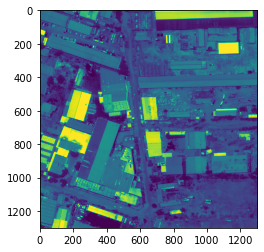

In [5]:
plt.imshow((valid_GTs[0]-255), cmap="Greys")
plt.imshow(samp_imgs[0])

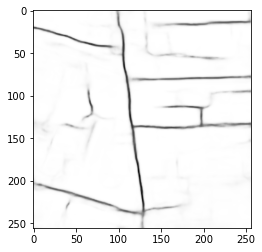

In [6]:
preds = model.predict(samp_resizes)
plt.imshow(preds[0][:,:,0], cmap="Greys")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


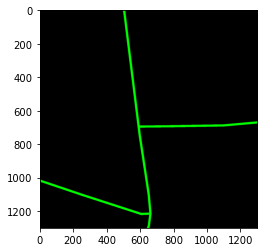

In [7]:
colorImg = cv2.cvtColor(samp_imgs[0], cv2.COLOR_GRAY2RGB)
img_shape = colorImg.shape
GTimg = np.zeros(img_shape)
GTimg[:,:,1] = valid_GTs[0]
plt.imshow(GTimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 1)


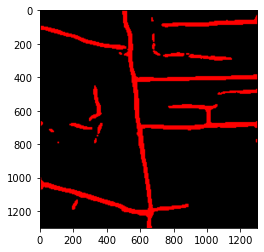

In [9]:
pred = preds[0][:,:]
pred = (pred * 255)
minImg = lambda x: 0.0 if(x < 40.0) else x
minImg = np.vectorize(minImg)
pred = minImg(pred)
print(pred.shape)
predReshape = cv2.resize(pred, img_shape[0:2])
predImg = np.zeros(img_shape)
predImg[:,:,0] = predReshape
plt.imshow(predImg)

In [20]:
blend = np.int16((0.75 * colorImg) + (2 * GTimg) + (2.5 * predImg))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


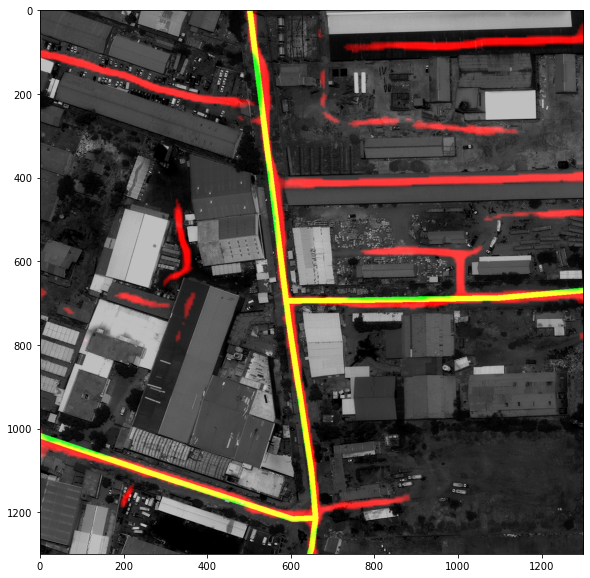

In [23]:
plt.figure(figsize = (10,10))
plt.imshow(blend)
plt.savefig('Road.png')